In [27]:
import pandas as pd
import numpy as np
import os
import kagglehub
import nltk
import pickle
import seaborn as sns
from google.colab import drive

from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yufengdev/bbc-fulltext-and-category")

print("Path to dataset files:", path)

100%|██████████| 1.83M/1.83M [00:00<00:00, 114MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/yufengdev/bbc-fulltext-and-category/versions/2


In [5]:
os.listdir(path)

['bbc-text.csv']

In [6]:
file_path=os.path.join(path,'bbc-text.csv')
data=pd.read_csv(file_path)
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [8]:
with open('/content/drive/MyDrive/ColabNotebooks/BBCNewsClassification/ stopwords.txt') as stopwords_file:
  stopwords=stopwords_file.readlines()
stopwords=[line.replace('\n','') for line in stopwords]
stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

In [13]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
nltk_stopwords=nltk.corpus.stopwords.words('english')
stopwords.extend(nltk_stopwords)

In [11]:
tokenizer=nltk.tokenize
stemmer=nltk.stem.porter.PorterStemmer()

In [14]:
dataset=pd.DataFrame(columns=['Body','Category'])
for index,row in data.iterrows():
  body_tokenized=tokenizer.word_tokenize(row['text'])
  body_tokenized_filtered=[w.lower() for w in body_tokenized if w.isalpha() and w.lower() not in set(stopwords)]
  body_tokenized_filtered_stemmed=[stemmer.stem(w) for w in body_tokenized_filtered]
  dataset.loc[index]={
      'Body':' '.join(body_tokenized_filtered_stemmed),
      'Category':row['category'].replace('\n','')
  }

In [15]:
dataset

,Body,Category
0,futur hand viewer theatr system plasma tv digi...,tech
1,worldcom boss left book worldcom boss berni eb...,business
2,tiger wari farrel gambl leicest rush bid andi ...,sport
3,yead newcastl fa cup premiership newcastl unit...,sport
4,ocean raid box offic ocean crime caper sequel ...,entertainment
...,...,...
2220,car pull retail figur retail sale fell januari...,business
2221,kilroy unveil immigr polici host robert attack...,politics
2222,rem glasgow concert band rem announc plan perf...,entertainment
2223,polit squabbl snowbal commonplac argu blair br...,politics


In [16]:
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(dataset['Body'])

In [17]:
le=LabelEncoder()
y=le.fit_transform(dataset['Category'])

In [18]:
np.shape(y)

(2225,)

In [19]:
np.shape(X)

(2225, 18264)

In [20]:
with open('/content/drive/MyDrive/ColabNotebooks/BBCNewsClassification/lion_v.h5','wb') as f:
  pickle.dump(vectorizer,f)
with open('/content/drive/MyDrive/ColabNotebooks/BBCNewsClassification/lion_le.h5','wb') as f:
  pickle.dump(le,f)

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=123)

In [23]:
params={
    'learning_rate':[0.01,0.05,0.1],
    'depth':[2,4,6],
    'n_estimators':[10,50,100]
}
model=CatBoostClassifier(random_state=123,task_type="GPU",devices='0')
grid=GridSearchCV(estimator=model,param_grid=params,cv=2,n_jobs=-1,verbose=1,scoring='accuracy')
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
0:	learn: 1.4839811	total: 76.3ms	remaining: 7.55s
1:	learn: 1.3935275	total: 152ms	remaining: 7.46s
2:	learn: 1.3141889	total: 229ms	remaining: 7.41s
3:	learn: 1.2460037	total: 289ms	remaining: 6.93s
4:	learn: 1.1808398	total: 326ms	remaining: 6.2s
5:	learn: 1.1253725	total: 365ms	remaining: 5.71s
6:	learn: 1.0822037	total: 394ms	remaining: 5.23s
7:	learn: 1.0414394	total: 428ms	remaining: 4.92s
8:	learn: 1.0000564	total: 452ms	remaining: 4.57s
9:	learn: 0.9660505	total: 471ms	remaining: 4.24s
10:	learn: 0.9319989	total: 493ms	remaining: 3.98s
11:	learn: 0.8947174	total: 514ms	remaining: 3.77s
12:	learn: 0.8663602	total: 535ms	remaining: 3.58s
13:	learn: 0.8383686	total: 556ms	remaining: 3.41s
14:	learn: 0.8141860	total: 577ms	remaining: 3.27s
15:	learn: 0.7922051	total: 596ms	remaining: 3.13s
16:	learn: 0.7703635	total: 621ms	remaining: 3.03s
17:	learn: 0.7492244	total: 640ms	remaining: 2.92s
18:	learn: 0.7290764	total: 657

In [25]:
model=grid.best_estimator_
cross_val_score(estimator=model,X=X_train,y=y_train,cv=3,n_jobs=-1,scoring='accuracy',verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.6s finished


array([0.94964029, 0.91906475, 0.90827338])

In [26]:
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       123
           1       0.94      0.89      0.92        94
           2       0.95      0.91      0.93       103
           3       0.93      0.97      0.95       131
           4       0.94      0.87      0.90       106

    accuracy                           0.92       557
   macro avg       0.93      0.92      0.92       557
weighted avg       0.92      0.92      0.92       557



<Axes: >

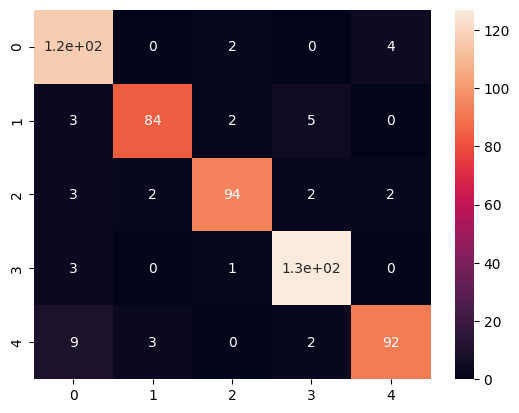

In [29]:
conf=confusion_matrix(y_test,y_pred)
sns.heatmap(conf,annot=True)

In [30]:
le.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [31]:
with open('/content/drive/MyDrive/ColabNotebooks/BBCNewsClassification/lion_model.h5','wb') as f:
  pickle.dump(model,f)